# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression  
from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.metrics import classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [2]:
df = pd.read_csv(r'C:\Users\Difta Alzena\Downloads\loan_data_2007_2014.csv', low_memory=False)

# Data Understanding

In [3]:
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(466285, 75)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# Penentuan Variabel Target

Target prediksi akan dibentuk berdasarkan kolom loan_status, namun perlu dilakukan proses transformasi terlebih dahulu.

In [6]:
df.loan_status.value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Beberapa status seperti ‘Current’ dan ‘In Grace Period’ menunjukkan pinjaman yang masih berjalan atau dalam masa tenggang, sehingga belum bisa dipastikan apakah tergolong pinjaman baik atau buruk. Oleh karena itu, entri dengan status tersebut akan dikeluarkan dari data.

In [7]:
# Menghapus baris dengan status yang belum bisa dipastikan
to_drop1 = ['Current', 'In Grace Period']
df = df[~df.loan_status.isin(to_drop1)]

Untuk keperluan klasifikasi, status pinjaman dikelompokkan menjadi dua kategori:
- Pinjaman berisiko rendah (good loan): 'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'
- Pinjaman berisiko tinggi (bad loan): semua status lainnya (misalnya Charged Off, Default, Late, dll.)

Label baru akan dibuat dalam bentuk numerik:
- 1 untuk good loan
- 0 untuk bad loan

In [8]:
# Mendefinisikan kategori pinjaman aman
low_risk = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

# Membuat kolom target biner
df['target'] = np.where(df['loan_status'].isin(low_risk), 1, 0)

Ukuran data setelah filter:

In [9]:
df.shape

(238913, 76)

Distribusi label target:

In [10]:
df['target'].value_counts()

1    186727
0     52186
Name: target, dtype: int64

Distribusi dalam bentuk proporsi:

In [11]:
df['target'].value_counts(normalize=True)

1    0.781569
0    0.218431
Name: target, dtype: float64

Terlihat bahwa data target tidak seimbang, dengan proporsi good loan jauh lebih besar dibanding bad loan. Oleh karena itu, langkah penanganan ketidakseimbangan data (imbalanced data handling) seperti upsampling dan downsampling akan dipertimbangkan pada tahap berikutnya.

# EDA

**Hubungan Status Pinjaman dengan Total Pembayaran yang Diterima**

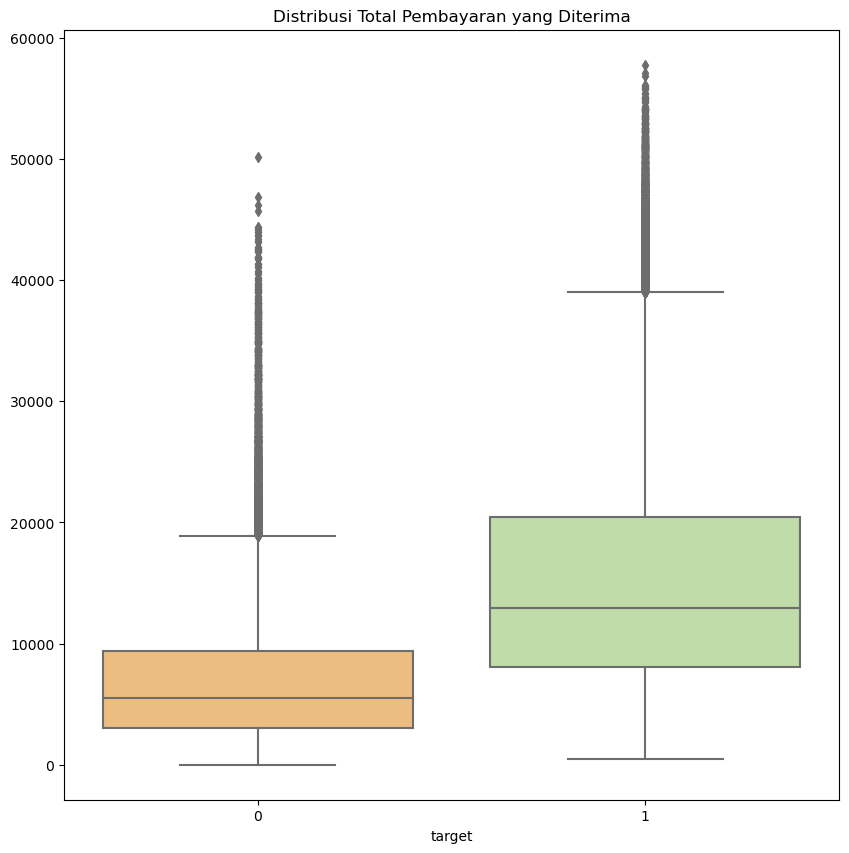

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,52186.0,7024.191781,5675.182531,0.00,3012.5975,5491.77000,9372.74250,50197.03000
1,186727.0,15160.113585,9452.545563,503.54,8035.1450,12930.93777,20429.38559,57777.57987


In [12]:
x = "target"
y = "total_pymnt"
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x=x, y=y, palette="Spectral")
plt.title("Distribusi Total Pembayaran yang Diterima")
plt.ylabel("")
plt.show()

df.groupby(x)[y].describe()

Dari grafik dan statistik di atas, dapat dilihat bahwa total pembayaran tertinggi umumnya berasal dari pinjaman yang sudah berhasil dilunasi (kategori baik)

**Status Pinjaman dan Besaran Pinjaman**

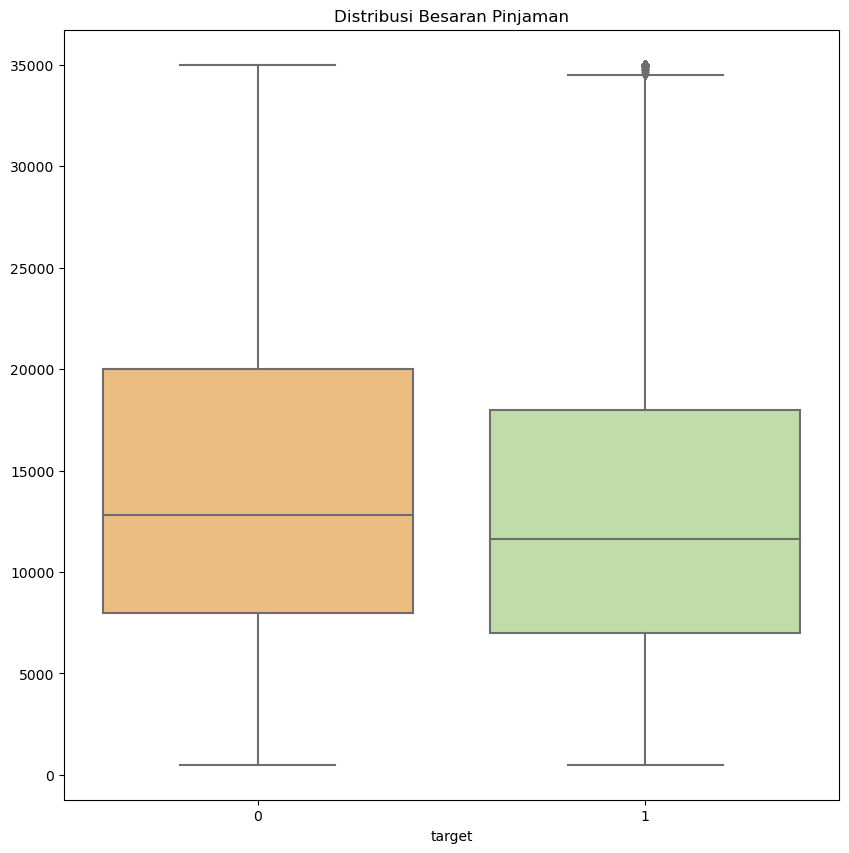

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,52186.0,14624.953053,8390.633508,500.0,8000.0,12800.0,20000.0,35000.0
1,186727.0,13167.962855,7944.742527,500.0,7000.0,11625.0,18000.0,35000.0


In [13]:
x = "target"
y = "loan_amnt"

plt.figure(figsize=(10,10))
sns.boxplot(data=df, x=x, y=y, palette="Spectral")
plt.title("Distribusi Besaran Pinjaman")
plt.ylabel("")
plt.show()

df.groupby(x)[y].describe()


Berdasarkan data, pinjaman dengan nilai total tertinggi justru berasal dari kelompok pinjaman yang gagal (bad loan), meskipun rata-rata pinjaman pada kelompok ini cenderung lebih besar dibanding yang sudah lunas.

**Tujuan Pengajuan Pinjaman**

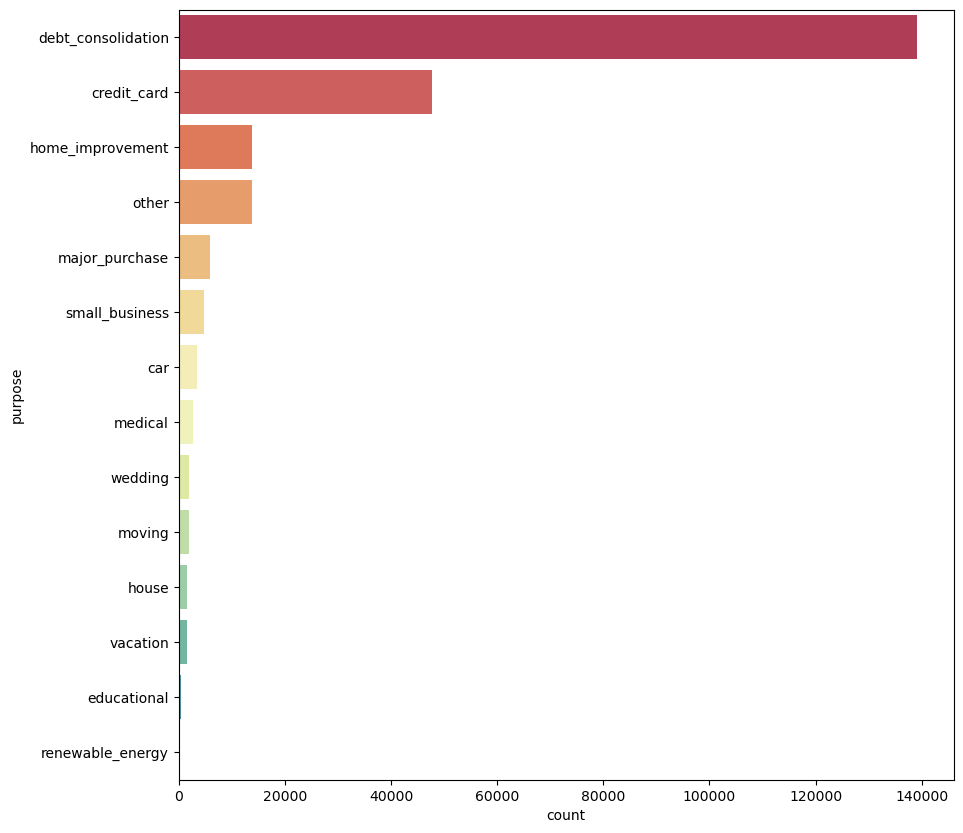

debt_consolidation    58.22%
credit_card           19.94%
home_improvement       5.81%
other                  5.74%
major_purchase         2.50%
small_business         2.01%
car                    1.47%
medical                1.14%
wedding                0.84%
moving                 0.80%
house                  0.64%
vacation               0.61%
educational            0.18%
renewable_energy       0.11%
Name: purpose, dtype: object


In [14]:
value_counts = df["purpose"].value_counts()

plt.figure(figsize=(10,10))
sns.countplot(y="purpose", order=value_counts.index, data=df, palette="Spectral")
plt.show()

percentage = value_counts / value_counts.sum()
percentage = percentage.apply("{:.2%}".format)
print(percentage)

Mayoritas peminjam menggunakan dana untuk melunasi hutang yang ada (debt consolidation), sementara tujuan lain seperti pendidikan, kesehatan, dan energi terbarukan relatif sedikit.

**Distribusi Peminjam Berdasarkan Negara Bagian**

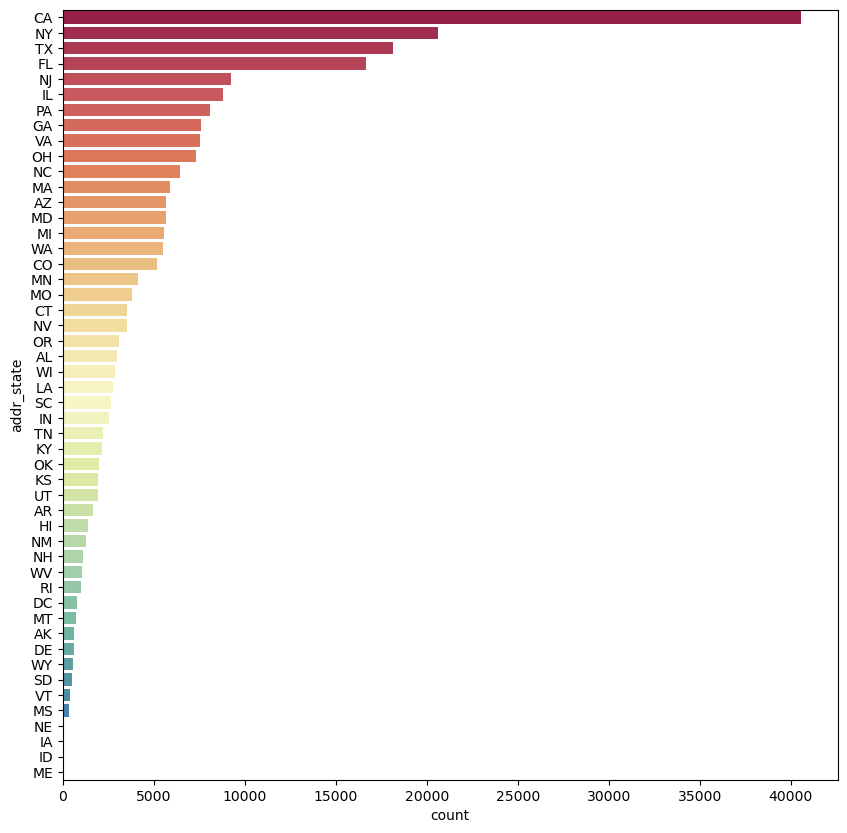

CA    16.97%
NY     8.63%
TX     7.60%
FL     6.97%
NJ     3.87%
IL     3.69%
PA     3.38%
GA     3.17%
VA     3.16%
OH     3.07%
NC     2.70%
MA     2.47%
AZ     2.38%
MD     2.38%
MI     2.33%
WA     2.31%
CO     2.17%
MN     1.73%
MO     1.59%
CT     1.49%
NV     1.49%
OR     1.30%
AL     1.24%
WI     1.21%
LA     1.16%
SC     1.11%
IN     1.06%
TN     0.94%
KY     0.90%
OK     0.84%
KS     0.82%
UT     0.81%
AR     0.70%
HI     0.57%
NM     0.54%
NH     0.46%
WV     0.45%
RI     0.43%
DC     0.33%
MT     0.30%
AK     0.26%
DE     0.26%
WY     0.23%
SD     0.22%
VT     0.17%
MS     0.14%
NE     0.01%
IA     0.01%
ID     0.00%
ME     0.00%
Name: addr_state, dtype: object


In [15]:
value_counts = df["addr_state"].value_counts()

plt.figure(figsize=(10,10))
sns.countplot(y="addr_state", order=value_counts.index, data=df, palette="Spectral")
plt.show()

percentage = value_counts / value_counts.sum()
percentage = percentage.apply("{:.2%}".format)
print(percentage)

Sebagian besar peminjam berasal dari California (CA), diikuti oleh New York (NY) dan Texas (TX).

**Status Kepemilikan Rumah Peminjam**

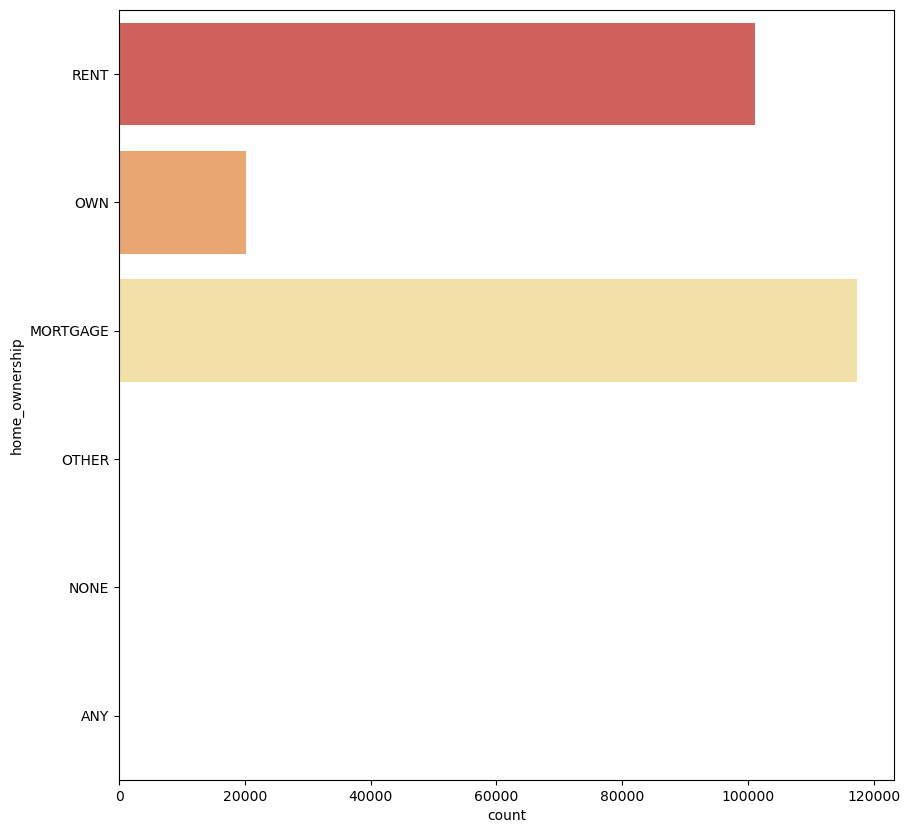

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(y="home_ownership", data=df, palette="Spectral")
plt.show()


Terlihat bahwa kebanyakan peminjam menggunakan rumah mereka sebagai jaminan pinjaman, sedangkan yang memiliki rumah secara pribadi lebih sedikit.

**Tingkat Suku Bunga Berdasarkan Grade Pinjaman**

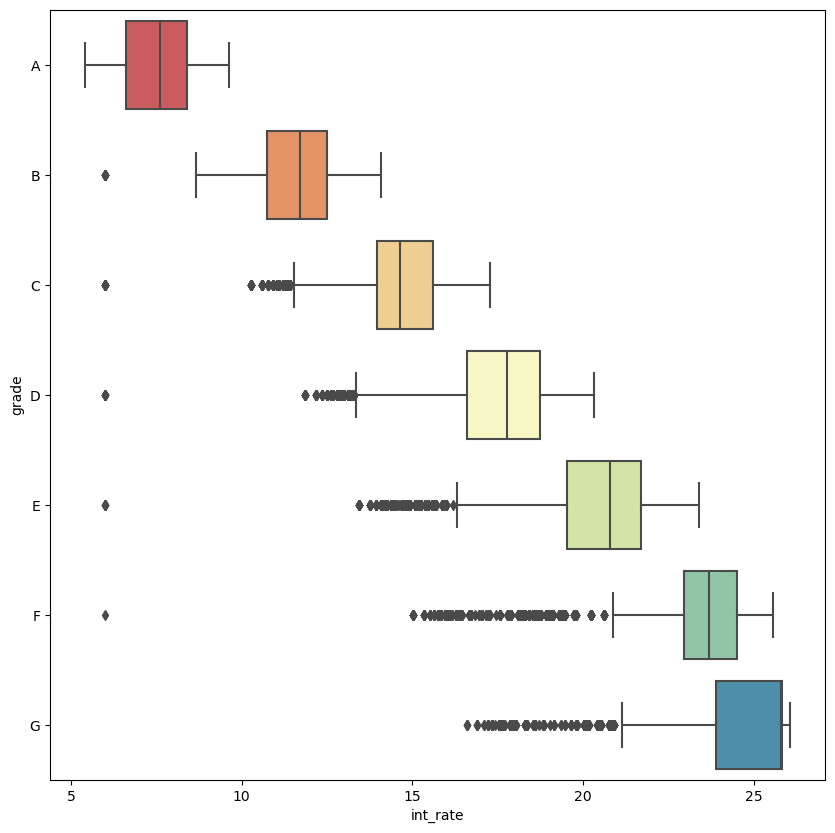

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,39500.0,7.548551,1.002864,5.42,6.62,7.62,8.39,9.63
B,72239.0,11.654911,1.280894,6.00,10.74,11.71,12.49,14.09
C,61042.0,14.760351,1.229674,6.00,13.98,14.64,15.61,17.27
D,38715.0,17.623237,1.474671,6.00,16.59,17.77,18.75,20.31
E,18086.0,20.362172,1.887752,6.00,19.52,20.80,21.70,23.40
F,7348.0,23.192361,2.053790,6.00,22.95,23.70,24.50,25.57
G,1983.0,24.290570,2.460741,16.59,23.91,25.80,25.83,26.06


In [17]:
x = "int_rate"
y = "grade"
order = df[y].sort_values().unique()

plt.figure(figsize=(10,10))
sns.boxplot(data=df, x=x, y=y, order=order, palette="Spectral")
plt.show()

df.groupby(y)[x].describe()

Tingkat suku bunga pinjaman cenderung meningkat dari grade A ke G, yang berarti semakin tinggi grade, semakin besar bunga yang dikenakan.

# Preprocessing

## Penanganan Data yang Hilang (Missing Values)

In [18]:
df_null = df.isnull().sum().reset_index()
df_null.columns = ["features", "missing_value"]
df_null['Percentage'] = (df_null["missing_value"] / df.shape[0]) * 100
df_null.sort_values(by='Percentage', ascending=False).reset_index(drop=True)

,features,missing_value,Percentage
0,open_acc_6m,238913,100.0
1,il_util,238913,100.0
2,verification_status_joint,238913,100.0
3,dti_joint,238913,100.0
4,annual_inc_joint,238913,100.0
...,...,...,...
71,total_pymnt,0,0.0
72,total_pymnt_inv,0,0.0
73,total_rec_prncp,0,0.0
74,total_rec_int,0,0.0


Output menunjukkan fitur-fitur dengan persentase nilai hilang tertinggi hingga terendah.

In [19]:
to_drop = df_null[df_null['Percentage'] > 25]['features']
to_drop

df.drop(to_drop, axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

Setelah menghapus kolom dengan nilai hilang lebih dari 25%, ukuran dataset menjadi:

In [20]:
df.shape

(238913, 50)

Untuk mengambil kolom dengan tipe data numerik:

In [21]:
df_num = df.select_dtypes(include='number')
df_num.shape

(238913, 30)

Selanjutnya, kolom yang memiliki nilai hilang kurang dari 25% akan diisi. Nilai numerik diisi dengan rata-rata (mean), sedangkan untuk kolom non-numerik diisi dengan modus (nilai yang paling sering muncul).

In [22]:
to_fill = df_null[(df_null['Percentage'] <= 25) & (df_null['Percentage'] > 0)]['features']

for feature in to_fill:
    if feature in df_num.columns:
        df[feature].fillna(int(df[feature].mean()), inplace=True)
    else:
        df[feature].fillna(str(df[feature].mode()), inplace=True)

Setelah proses pengisian nilai hilang, pengecekan jumlah nilai kosong dilakukan:

In [23]:
print(df.isna().sum().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Semua nilai kosong telah terisi, sehingga output berupa daftar nol untuk setiap kolom.

Selain itu, pengecekan data duplikat juga dilakukan untuk memastikan tidak ada baris data yang sama.

In [24]:
df.duplicated().sum()

0

Hasilnya adalah: 0, yang berarti tidak ditemukan data duplikat.

Terakhir, informasi ringkas mengenai dataset dapat diperoleh dengan:

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          238913 non-null  int64  
 1   member_id                   238913 non-null  int64  
 2   loan_amnt                   238913 non-null  int64  
 3   funded_amnt                 238913 non-null  int64  
 4   funded_amnt_inv             238913 non-null  float64
 5   term                        238913 non-null  object 
 6   int_rate                    238913 non-null  float64
 7   installment                 238913 non-null  float64
 8   grade                       238913 non-null  object 
 9   sub_grade                   238913 non-null  object 
 10  emp_title                   238913 non-null  object 
 11  emp_length                  238913 non-null  object 
 12  home_ownership              238913 non-null  object 
 13  annual_inc    

Hasil ini menunjukkan preprocessing telah berhasil dilakukan.

# Pemilihan Fitur (Feature Selection)

In [26]:
df_obj = df.select_dtypes(include='object')

In [27]:
unique_obj = df_obj.nunique()
unique_num = df_num.nunique()

Pada tahap ini, kita mencari fitur numerik dan non-numerik yang memiliki nilai unik sebanyak 1 (konstan), nilai unik sebanyak total baris (unik semua), serta fitur non-numerik yang memiliki jumlah nilai unik sangat banyak (> 500). Nantinya, fitur-fitur ini akan kita hapus.

In [28]:
single_obj_colname = unique_obj[unique_obj == 1].index.to_list()
single_num_colname = unique_num[unique_num == 1].index.to_list()

print(single_obj_colname)
print(single_num_colname)

['application_type']
['policy_code']


Selanjutnya, kita identifikasi fitur yang semua nilainya unik (jumlah unik = jumlah data):

In [29]:
unique_obj_colname = unique_obj[unique_obj == df.shape[0]].index.to_list()
unique_num_colname = unique_num[unique_num == df.shape[0]].index.to_list()

print(unique_obj_colname)
print(unique_num_colname)

['url']
['id', 'member_id']


Kemudian, kita cari fitur non-numerik yang memiliki banyak sekali nilai unik (lebih dari 500):

In [30]:
mul_obj_colname = unique_obj[unique_obj > 500].index.to_list()
print(mul_obj_colname)

['emp_title', 'url', 'title', 'zip_code', 'earliest_cr_line']


Semua fitur tersebut kita gabungkan ke dalam daftar penghapusan:

In [31]:
remove = single_obj_colname + single_num_colname + unique_obj_colname + unique_num_colname + mul_obj_colname

Kemudian kita buat dataset baru dengan menghapus fitur-fitur tersebut:

In [32]:
new_df = df.loc[:, ~df.columns.isin(remove)].copy()
new_df.shape

(238913, 41)

Untuk melihat data baru awalnya:

In [33]:
new_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,target
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,861.07,0.00,0.00,0.00,Jan-15,171.62,Jan-16,0.0,0.0,1
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,0.0,0
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,603.65,0.00,0.00,0.00,Jun-14,649.91,Jan-16,0.0,0.0,1
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,2209.33,16.97,0.00,0.00,Jan-15,357.48,Jan-15,0.0,0.0,1
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,...,631.38,0.00,0.00,0.00,Jan-15,161.03,Sep-15,0.0,0.0,1


In [34]:
new_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'target'],
      dtype='object')

Beberapa fitur berikut memberikan informasi yang secara langsung bisa memprediksi target. Jika fitur-fitur ini tetap digunakan saat pelatihan model, hasilnya bisa sangat bagus secara palsu karena adanya data leakage — informasi dari fitur-fitur tersebut sudah mengandung hasil yang ingin diprediksi. Oleh karena itu, fitur-fitur ini harus dihapus agar model yang dibangun benar-benar valid.

Fitur-fitur yang termasuk data leakage adalah:
- 'issue_d' : Bulan pinjaman diberikan
- 'loan_status' : Status pinjaman saat ini
- 'pymnt_plan' : Rencana pembayaran
- 'out_prncp' : Sisa pokok pinjaman yang harus dibayar secara keseluruhan
- 'out_prncp_inv' : Sisa pokok pinjaman dari investor
- 'total_pymnt' : Total pembayaran yang telah diterima
- 'total_pymnt_inv' : Total pembayaran dari investor yang telah diterima
- 'total_rec_prncp' : Pokok pinjaman yang sudah diterima
- 'total_rec_int' : Bunga yang sudah diterima
- 'total_rec_late_fee' : Denda keterlambatan yang sudah diterima
- 'recoveries' : Status apakah ada rencana pembayaran
- 'collection_recovery_fee' : Biaya koleksi setelah pinjaman macet
- 'last_pymnt_d' : Bulan terakhir pembayaran diterima
- 'last_pymnt_amnt' : Jumlah pembayaran terakhir

In [35]:
leak_col = ['issue_d', 'loan_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
            'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
            'last_pymnt_d', 'last_pymnt_amnt']

Hapus fitur-fitur tersebut dari dataset:

In [36]:
new_df.drop(columns=leak_col, axis=1, inplace=True)

Selain itu, kita juga hapus beberapa kolom lain yang tidak diperlukan:

In [37]:
new_df.drop(columns='sub_grade', axis=1, inplace=True)
new_df.drop(columns='last_credit_pull_d', axis=1, inplace=True)

Ukuran data setelah penghapusan fitur-fitur tersebut:

In [38]:
new_df.shape

(238913, 26)

Dan daftar kolom terakhir:

In [39]:
new_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'target'],
      dtype='object')

# Rekayasa Fitur (Feature Engineering)

In [40]:
new_df.select_dtypes(include='object')

,term,grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,initial_list_status
0,36 months,B,10+ years,RENT,Verified,n,credit_card,AZ,f
1,60 months,C,< 1 year,RENT,Source Verified,n,car,GA,f
2,36 months,C,10+ years,RENT,Not Verified,n,small_business,IL,f
3,36 months,C,10+ years,RENT,Source Verified,n,other,CA,f
5,36 months,A,3 years,RENT,Source Verified,n,wedding,AZ,f
...,...,...,...,...,...,...,...,...,...
466276,60 months,D,5 years,MORTGAGE,Verified,n,medical,MA,f
466277,36 months,A,3 years,RENT,Verified,n,debt_consolidation,MD,f
466278,36 months,D,10+ years,RENT,Source Verified,n,vacation,VA,f
466281,60 months,D,10+ years,MORTGAGE,Verified,n,debt_consolidation,TN,f


**Label Encoding**

Label encoding diterapkan pada fitur yang memiliki urutan atau tingkatan (ordinal), sehingga nilainya bisa diubah ke bentuk numerik yang mencerminkan peringkat.

1. Contoh pertama, kita lihat distribusi nilai pada kolom 'term':

In [41]:
new_df['term'].value_counts()

 36 months    186469
 60 months     52444
Name: term, dtype: int64

Langkah berikutnya adalah mengubah nilai string 'term' menjadi integer, dengan menghapus kata " months" dan mengkonversinya ke tipe int:

In [42]:
new_df['term'] = new_df['term'].str.replace(' months', '').astype(int)

2. Untuk kolom 'grade' yang menunjukkan kelas atau peringkat, kita cek jumlah setiap kategori:

In [43]:
new_df['grade'].value_counts()

B    72239
C    61042
A    39500
D    38715
E    18086
F     7348
G     1983
Name: grade, dtype: int64

Lalu kita lakukan mapping nilai huruf ke angka sesuai urutan grade dari terbaik ke terburuk:

In [44]:
grade_new = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
new_df['grade'] = new_df['grade'].map(grade_new)

3. Selanjutnya, untuk kolom 'emp_length' (lama bekerja), kita lihat jumlah tiap kategori:

In [45]:
new_df['emp_length'].value_counts()

10+ years                                          71312
2 years                                            22352
< 1 year                                           19998
3 years                                            19395
5 years                                            17297
1 year                                             16078
4 years                                            15402
6 years                                            14300
7 years                                            13466
8 years                                            11092
0    10+ years\nName: emp_length, dtype: object     9225
9 years                                             8996
Name: emp_length, dtype: int64

Output berupa data kategori lama kerja dengan berbagai rentang tahun. Kemudian kita buat mapping ke angka sesuai urutan lama kerja:

In [46]:
empl_new = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, 
            '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, 
            '10+ years': 10, '0    10+ years\ndtype: object': 10}
new_df['emp_length'] = new_df['emp_length'].map(empl_new)

4. Untuk kolom 'home_ownership', kita lihat distribusi nilainya:

In [47]:
new_df['home_ownership'].value_counts()

MORTGAGE    117376
RENT        101186
OWN          20123
OTHER          179
NONE            48
ANY              1
Name: home_ownership, dtype: int64

Lalu kita samakan nilai 'NONE' dan 'ANY' menjadi 'OTHER' agar konsisten:

In [48]:
home_new = {'NONE': 'OTHER', 'ANY': 'OTHER'}
new_df['home_ownership'] = new_df['home_ownership'].map(home_new)

5. Untuk fitur 'initial_list_status', yang berisi status awal daftar, kita ubah kategori huruf menjadi angka biner:

In [49]:
new_df['initial_list_status'].value_counts()

f    177714
w     61199
Name: initial_list_status, dtype: int64

Lalu mapping:

In [50]:
init_new = {'f': 1, 'w': 0}
new_df['initial_list_status'] = new_df['initial_list_status'].map(init_new)

**One-hot Encoding**

One-hot encoding digunakan pada fitur kategorikal yang tidak memiliki urutan atau tingkatan tertentu sehingga tidak bisa di-label encode.

Contoh fitur yang akan di-one-hot encode:

In [51]:
new_df['verification_status'].unique()
new_df['purpose'].unique()
new_df['addr_state'].unique()

array(['AZ', 'GA', 'IL', 'CA', 'TX', 'VA', 'MO', 'CT', 'UT', 'FL', 'NY',
       'PA', 'MN', 'NJ', 'OR', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA', 'WA',
       'WI', 'AL', 'NV', 'AK', 'CO', 'MD', 'WV', 'VT', 'MI', 'DC', 'SD',
       'NC', 'AR', 'NM', 'KS', 'HI', 'OK', 'MT', 'WY', 'NH', 'DE', 'MS',
       'TN', 'IA', 'NE', 'ID', 'IN', 'ME'], dtype=object)

Untuk melakukan one-hot encoding pada fitur-fitur tersebut:

In [52]:
onehot = ['verification_status', 'purpose', 'addr_state']
dummy = pd.get_dummies(new_df[onehot])

**Seleksi Fitur berdasarkan Korelasi dengan Target**

Kita analisis korelasi fitur numerik terhadap target untuk memilih fitur-fitur yang paling berpengaruh secara positif dan negatif.

Fitur dengan korelasi negatif paling besar (top 5):

In [53]:
new_df.corr()['target'][:].sort_values(ascending=True).head(5)

int_rate     -0.255543
grade        -0.250580
term         -0.175030
dti          -0.128055
revol_util   -0.098346
Name: target, dtype: float64

Fitur dengan korelasi positif paling besar (top 5)

In [54]:
new_df.corr()['target'][:].sort_values(ascending=False).head(5)

target                 1.000000
annual_inc             0.060564
initial_list_status    0.039365
total_acc              0.021682
revol_bal              0.001998
Name: target, dtype: float64

Dari hasil korelasi, kita pilih kolom-kolom yang relevan:

In [55]:
cor_col = ['target', 'int_rate', 'grade', 'term', 'dti', 'revol_util', 
           'annual_inc', 'initial_list_status', 'total_acc', 'revol_bal']
cor_df = new_df[cor_col].copy()

**Menggabungkan Data Korelasi dan One-hot Encoding**

Gabungkan dataset fitur korelasi dengan hasil one-hot encoding:

In [56]:
concat_df = pd.concat([cor_df, dummy], axis=1)
concat_df.shape

(238913, 77)

# Penanganan Ketidakseimbangan Kelas (Imbalance Handling)

Pertama, mari kita lihat distribusi dari variabel target:

In [57]:
concat_df['target'].value_counts()

1    186727
0     52186
Name: target, dtype: int64

Untuk mengetahui proporsinya:

In [58]:
concat_df['target'].value_counts(normalize=True)

1    0.781569
0    0.218431
Name: target, dtype: float64

Terlihat jelas bahwa data sangat tidak seimbang, dengan mayoritas data adalah kelas 1 (good loan). Oleh karena itu, dilakukan dua pendekatan:
- Oversampling terhadap kelas minoritas (bad loan / 0)
- Undersampling terhadap kelas mayoritas (good loan / 1)

In [59]:
df_major = concat_df[(concat_df['target']==0)]  # data untuk kelas 0
df_minor = concat_df[(concat_df['target']==1)]  # data untuk kelas 1

# Membuat ulang data dengan oversampling dan undersampling agar seimbang
df_minor_up = resample(df_minor, replace=True, n_samples=119456, random_state=42)
df_major_down = resample(df_major, replace=True, n_samples=119456, random_state=42)

# Menggabungkan kembali menjadi satu dataframe
df_upsampled = pd.concat([df_minor_up, df_major_down])

Memastikan bahwa data sekarang sudah seimbang:

In [60]:
df_upsampled['target'].value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

Struktur data hasil resampling:

In [61]:
df_upsampled.head()

,target,int_rate,grade,term,dti,revol_util,annual_inc,initial_list_status,total_acc,revol_bal,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
217852,1,10.74,2,36,19.85,33.6,22000.0,1,11.0,3358,...,0,0,1,0,0,0,0,0,0,0
316157,1,6.49,1,36,18.06,41.1,60000.0,0,25.0,11546,...,0,0,0,0,0,1,0,0,0,0
230539,1,14.27,3,60,18.74,95.0,88000.0,1,16.0,18998,...,0,0,0,0,0,0,0,0,0,0
194264,1,14.33,3,36,13.80,65.5,38000.0,1,9.0,9568,...,0,0,0,0,0,0,0,0,0,0
215135,1,6.62,1,36,4.23,20.4,125000.0,1,25.0,9010,...,0,0,0,0,0,0,0,0,0,0


# Standardisasi Nilai (Standardization)

Agar setiap fitur berada dalam skala yang seragam (umumnya dibutuhkan pada model berbasis jarak atau gradien), dilakukan standardisasi menggunakan StandardScaler dari sklearn.

Standardisasi dilakukan ke seluruh kolom, termasuk fitur hasil one-hot encoding.

In [62]:
for i in df_upsampled.columns:
  scale = StandardScaler().fit(df_upsampled[[i]])
  df_upsampled[i] = scale.transform(df_upsampled[[i]])

Setelah distandarisasi, kita bisa lihat kembali isi dataframe:

In [63]:
df_upsampled.head()

,target,int_rate,grade,term,dti,revol_util,annual_inc,initial_list_status,total_acc,revol_bal,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
217852,1.0,-0.868912,-0.744832,-0.607742,0.350031,-0.951917,-0.899016,0.602514,-1.172083,-0.603726,...,-0.047375,-0.104831,3.556762,-0.089011,-0.181164,-0.039650,-0.152602,-0.110014,-0.06355,-0.044586
316157,1.0,-1.821496,-1.466816,-0.607742,0.121130,-0.642365,-0.180985,-1.659713,0.033477,-0.185334,...,-0.047375,-0.104831,-0.281155,-0.089011,-0.181164,25.220997,-0.152602,-0.110014,-0.06355,-0.044586
230539,1.0,-0.077708,-0.022849,1.645434,0.208087,1.582284,0.348090,0.602514,-0.741526,0.195450,...,-0.047375,-0.104831,-0.281155,-0.089011,-0.181164,-0.039650,-0.152602,-0.110014,-0.06355,-0.044586
194264,1.0,-0.064259,-0.022849,-0.607742,-0.423629,0.364712,-0.596687,0.602514,-1.344306,-0.286406,...,-0.047375,-0.104831,-0.281155,-0.089011,-0.181164,-0.039650,-0.152602,-0.110014,-0.06355,-0.044586
215135,1.0,-1.792358,-1.466816,-0.607742,-1.647418,-1.496729,1.047226,0.602514,0.033477,-0.314919,...,-0.047375,-0.104831,-0.281155,-0.089011,-0.181164,-0.039650,-0.152602,-0.110014,-0.06355,-0.044586


Nilai-nilai dalam dataset sekarang telah berubah ke bentuk standar (rata-rata = 0 dan standar deviasi = 1), baik untuk fitur numerik maupun yang sebelumnya dikonversi dari kategorikal.

# Pemodelan (Modeling)

Langkah awal dalam membangun model adalah memisahkan fitur (variabel input) dan target (label output). Target yang digunakan adalah kolom 'target', sedangkan fitur lainnya digunakan untuk melatih model.

In [64]:
# Memisahkan data fitur dan label
X = df_upsampled.drop('target', axis=1)  # variabel independen
y = df_upsampled['target']               # variabel dependen (label)

Setelah itu, dilakukan pembagian data menjadi data latih (training) dan data uji (testing). Pembagian ini penting agar kita bisa menguji performa model terhadap data yang belum pernah dilihat sebelumnya.

In [65]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi training dan testing set
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Ubah semua -1.0 menjadi 0 agar kompatibel dengan semua model (terutama XGBoost)
y_train = y_train.replace(-1.0, 0)
y_test = y_test.replace(-1.0, 0)


Beberapa model machine learning yang akan digunakan untuk klasifikasi data ini antara lain:
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier
- K-Nearest Neighbors (KNN)
- Logistic Regression ← (ditambahkan sebagai model tambahan)

Model-model ini dipilih karena masing-masing memiliki keunggulan tersendiri, mulai dari interpretabilitas (Decision Tree, Logistic Regression) hingga akurasi tinggi dan kestabilan (Random Forest, XGBoost).

# Training Model dan Evaluasi

Setelah data dipisahkan menjadi training set dan testing set, kita melatih beberapa algoritma klasifikasi dan mengevaluasi performanya. Evaluasi dilakukan menggunakan precision, recall, dan f1-score berdasarkan hasil prediksi pada data uji.



**1. Decision Tree Classifier**

Model ini menggunakan struktur pohon keputusan untuk memetakan input ke target. Cocok digunakan untuk interpretasi yang mudah.

In [66]:
# Decision Tree Classifier
dtree = DecisionTreeClassifier(random_state = 42)
dtree = dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.86     29965
         1.0       0.89      0.79      0.84     29763

    accuracy                           0.85     59728
   macro avg       0.85      0.85      0.85     59728
weighted avg       0.85      0.85      0.85     59728



**2. Random Forest Classifier**

Merupakan ensemble method yang menggabungkan beberapa decision tree, meningkatkan akurasi dan mengurangi overfitting.

In [67]:
# Random Forest Classifier
randof = RandomForestClassifier(random_state = 42)
randof.fit(x_train, y_train)
y_pred = randof.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89     29965
         1.0       0.90      0.85      0.88     29763

    accuracy                           0.88     59728
   macro avg       0.88      0.88      0.88     59728
weighted avg       0.88      0.88      0.88     59728



Hasil Evaluasi:
- Kinerja merata pada kedua kelas
- Akurasi keseluruhan: 88% (tertinggi di antara model lain)

**3. XGBoost Classifier**

Model boosting yang kuat dan sering digunakan untuk kompetisi machine learning. Meski kuat, ia sensitif terhadap skala dan data tidak seimbang

In [68]:
#XGBoost
xgb = XGBClassifier(random_state = 42)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69     29965
         1.0       0.69      0.67      0.68     29763

    accuracy                           0.69     59728
   macro avg       0.69      0.69      0.69     59728
weighted avg       0.69      0.69      0.69     59728



**4. K-Nearest Neighbors (KNN)**

Model ini mengklasifikasikan berdasarkan kedekatan jarak dengan tetangga terdekat. Cenderung lambat jika dataset besar.

In [69]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.74      0.71     29965
         1.0       0.72      0.65      0.68     29763

    accuracy                           0.70     59728
   macro avg       0.70      0.70      0.70     59728
weighted avg       0.70      0.70      0.70     59728



**5. Logistic Regression**

Model linier yang cocok untuk prediksi kelas biner. Sangat cepat dan sering digunakan sebagai baseline dalam klasifikasi.

In [70]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64     29965
         1.0       0.64      0.66      0.65     29763

    accuracy                           0.65     59728
   macro avg       0.65      0.65      0.65     59728
weighted avg       0.65      0.65      0.65     59728

